# Building a biorefinery

Putting it all together, we can finally build a complete biorefinery from scratch. The following examples should help guide this process.

## Sugarcane biorefinery

In this example, a sugarcane biorefinery for the production of ethanol is designed according to [[1]](#References), including all process setings, prices, and assumptions. Some heat integration is not included here for simplicity. First create the thermodynamic property package to define the chemicals in the process. We can follow the [example](https://thermosteam.readthedocs.io/en/latest/tutorial/Thermo%20property%20packages.html) in Thermosteam's docs to do this:

In [1]:
from thermosteam import functional as fn # Useful functions for building chemicals
import biosteam as bst

# %% Define common chemicals
chemicals = bst.Chemicals(
    ['Water', 'Ethanol', 'Glucose', 'Sucrose',
     'H3PO4', 'P4O10', 'CO2', 'Octane', 'O2'])
(Water,  Ethanol, Glucose, Sucrose,
 H3PO4, P4O10, CO2, Octane, O2) = chemicals
for i in (O2, CO2): i.at_state(phase='g')
for i in (H3PO4, P4O10, Glucose, Sucrose): i.at_state(phase='s')

# %% Define new chemicals

def create_new_chemical(ID, phase='s', **constants):
    solid = bst.Chemical.blank(ID, phase=phase, **constants)
    chemicals.append(solid)
    return solid

Ash = create_new_chemical('Ash', MW=1.)
Cellulose = create_new_chemical('Cellulose',
                                formula="C6H10O5", # Glucose monomer minus water
                                Hf=-975708.8)
Hemicellulose = create_new_chemical('Hemicellulose',
                                    formula="C5H8O5", # Xylose monomer minus water
                                    Hf=-761906.4)
Flocculant = create_new_chemical('Flocculant',
                                 MW=1.)
Lignin = create_new_chemical('Lignin',
                             formula='C8H8O3', # Vainillin formula
                             Hf=-452909.632)
Solids = create_new_chemical('Solids',
                             MW=1.)
DryYeast = create_new_chemical('DryYeast',
                               MW=1.,
                               CAS='Yeast')
CaO = create_new_chemical('CaO',
                          formula='CaO')

# %% Fill missing properties

# Insolubles occupy a significant volume
insoluble_solids = (Ash, Cellulose, Hemicellulose,
                    Flocculant, Lignin, Solids, DryYeast, P4O10)

# Solubles don't occupy much volume
soluble_solids = (CaO, H3PO4, Glucose, Sucrose) 

for chemical in insoluble_solids:
    V = fn.rho_to_V(rho=1540, MW=chemical.MW)
    chemical.V.add_model(V, top_priority=True)

for chemical in soluble_solids:
    V = fn.rho_to_V(rho=1e4, MW=chemical.MW)
    chemical.V.add_model(V, top_priority=True)

# Add constant models for molar heat capacity of solids
Ash.Cn.add_model(0.09 * 4.184 * Ash.MW) 
CaO.Cn.add_model(1.02388 * CaO.MW) 
Cellulose.Cn.add_model(1.364 * Cellulose.MW) 
Hemicellulose.Cn.add_model(1.364 * Hemicellulose.MW)
Flocculant.Cn.add_model(4.184 * Flocculant.MW)
Lignin.Cn.add_model(1.364 * Lignin.MW)
Solids.Cn.add_model(1.100 * Solids.MW)

for chemical in chemicals:
    chemical.default()

chemicals.compile()
chemicals.set_synonym('Water', 'H2O')

bst.settings.set_thermo(chemicals)

Define process settings:

In [2]:
bst.CE = 567 # 2013
bst.PowerUtility.price = 0.065
HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = HeatUtility.get_agent('low_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.regeneration_price = 0.30626
steam_utility.T = 529.2
steam_utility.P = 44e5

# Cooling water and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
HeatUtility.get_agent('cooling_water').regeneration_price = 0
HeatUtility.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Sugar cane': 0.03455, # 70% m.c
         'Water': 0.000353,
         'HCl': 0.205,
         'Lime': 0.077,
         'H3PO4': 0, # Not significant
         'NaOH':0.41,
         'Protease': 0.5,
         'Polymer': 0, # Not significant
         'Steam': 0.017,
         'Ethanol': 0.789,
         'Waste': -0.33,
         'Gasoline': 0.756} # 2 USD/gal

Define unit operations in the feedstock handling and juicing section:

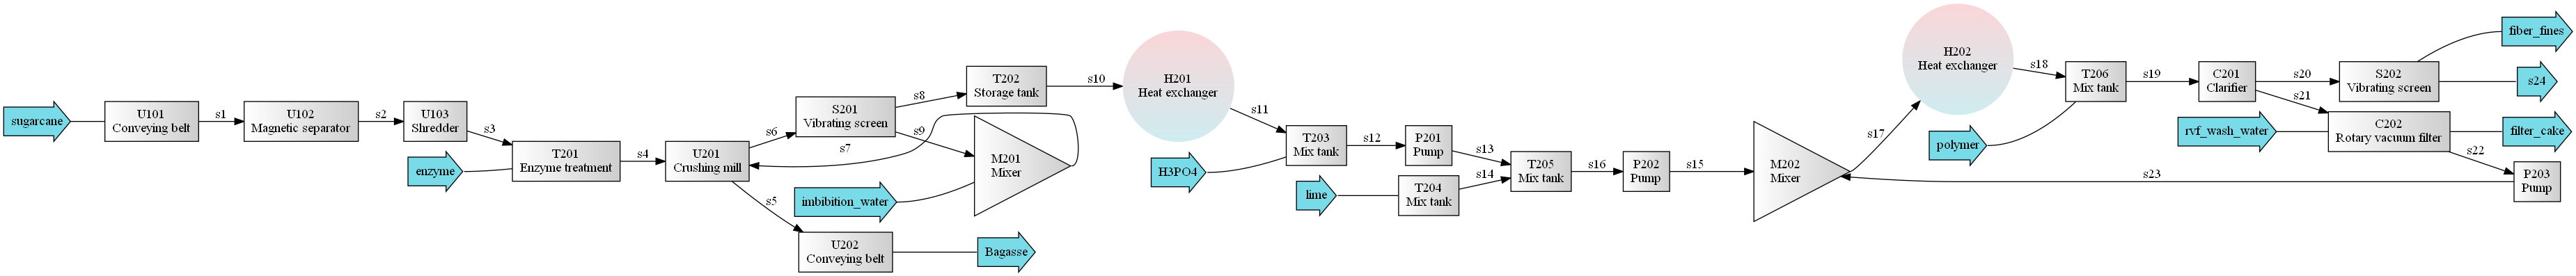

In [3]:
from biosteam import units
import numpy as np

bst.main_flowsheet.set_flowsheet('sugarcane_ethanol')

z_mass_sugarcane = chemicals.kwarray(
    dict(Glucose=0.0120811,
         Lignin=0.0327653,
         Solids=0.015,
         Sucrose=0.136919,
         Ash=0.006,
         Cellulose=0.0611531,
         Hemicellulose=0.036082,
         Water=0.7)
)

sugarcane = bst.Stream('sugarcane',
                       flow=333334 * z_mass_sugarcane,
                       units='kg/hr',
                       price=price['Sugar cane'])

enzyme = bst.Stream('enzyme',
                    Cellulose=100, Water=900, units='kg/hr',
                    price=price['Protease'])

imbibition_water = bst.Stream('imbibition_water',
                              Water=87023.35, units='kg/hr',
                              T = 338.15)

H3PO4 = bst.Stream('H3PO4',
                   H3PO4=74.23, Water=13.10, units='kg/hr',
                   price=price['H3PO4'])  # to T203

lime = bst.Stream('lime',
                  CaO=333.00, Water=2200.00, units='kg/hr',
                  price=price['Lime'])  # to P5

polymer = bst.Stream('polymer',
                     Flocculant=0.83, units='kg/hr',
                     price=price['Polymer'])  # to T205

rvf_wash_water = bst.Stream('rvf_wash_water',
                            Water=16770, units='kg/hr',
                            T=363.15)  # to C202

### Unit operations ###

# Feed the shredder
U101 = units.ConveyingBelt('U101', ins=sugarcane)

# Separate metals
U102 = units.MagneticSeparator('U102', ins=U101-0)

# Shredded cane
U103 = units.Shredder('U103', ins=U102-0)

# Hydrolyze starch
T201 = units.EnzymeTreatment('T201', T=323.15)  # T=50

# Finely crush lipid cane
U201 = units.CrushingMill('U201',
                          split=dict(Ash=0.92,
                                     Cellulose=0.92,
                                     Glucose=0.04,
                                     Hemicellulose=0.92,
                                     Lignin=0.92,
                                     Sucrose=0.04,
                                     Solids=1),
                          moisture_content=0.5)

# Convey out bagasse
U202 = units.ConveyingBelt('U202', ins=U201.outs[0], outs='Bagasse')

# Mix in water
M201 = units.Mixer('M201')
# crushing_mill_recycle_sys = bst.System('crushing_mill_recycle_sys',
#                                path=(U201, S201, M201),
#                                recycle=M201-0)

# Screen out fibers
S201 = units.VibratingScreen('S201',
                             split=dict(Ash=0.35,
                                        Cellulose=0.35,
                                        Glucose=0.88,
                                        Hemicellulose=0.35,
                                        Lignin=0.35,
                                        Solids=0,
                                        Sucrose=0.88,
                                        Water=0.88))

# Store juice before treatment
T202 = units.StorageTank('T202', tau=4, vessel_material='Carbon steel')

# Heat up before adding acid
H201 = units.HXutility('H201', T=343.15)

# Mix in acid
T203 = units.MixTank('T203')

# Pump acid solution
P201 = units.Pump('P201')

# Mix lime solution
T204 = units.MixTank('T204', tau=0.10)
P202 = units.Pump('P202')

# Blend acid lipid solution with lime
T205 = units.MixTank('T205', tau=0.10)

# Mix recycle
M202 = units.Mixer('M202')

# Heat before adding flocculant
H202 = units.HXutility('H202', T=372.15)

# Mix in flocculant
T206 = units.MixTank('T206')
T206.tau = 0.10

# Separate residual solids
C201 = units.Clarifier('C201',
                       split=dict(Ash=0,
                                  CaO=0,
                                  Cellulose=0,
                                  Flocculant=0.522,
                                  Glucose=0.522,
                                  Hemicellulose=0,
                                  Lignin=0,
                                  H3PO4=0.522,
                                  Sucrose=0.522,
                                  Water=0.522))

# Remove solids as filter cake
C202 = units.RVF('C202', 
                 outs=('filter_cake', ''),
                 moisture_content=0.80,
                 split=dict(Ash=0.85,
                            CaO=0.85,
                            Cellulose=0.85,
                            Glucose=0.01,
                            Hemicellulose=0.85,
                            Lignin=0.85,
                            Sucrose=0.01))
P203 = units.Pump('P203')


# Screen out small fibers from sugar stream
S202 = units.VibratingScreen('S202', outs=('', 'fiber_fines'),
                             split=dict(Ash=1.0,
                                        CaO=1.0,
                                        Cellulose=1.0,
                                        Flocculant=0.0,
                                        Glucose=0.998,
                                        Hemicellulose=1.0,
                                        Lignin=1.0,
                                        H3PO4=1.0,
                                        Sucrose=0.998,
                                        Water=0.998))
S202.mesh_opening = 2

### Process specifications ###

# Specifications dependent on lipid cane flow rate
def correct_flows():
    U103._run()
    F_mass = sugarcane.F_mass
    # correct enzyme, lime, phosphoric acid, and imbibition water
    enzyme.imass['Cellulose', 'Water'] = 0.003 * F_mass * np.array([0.1, 0.9])
    lime.imass['CaO', 'Water'] = 0.001 * F_mass * np.array([0.046, 0.954])
    H3PO4.imass['H3PO4', 'Water'] = 0.00025 * F_mass
    imbibition_water.imass['Water'] = 0.25* F_mass

U103.specification = correct_flows

# Specifications within a system
def correct_wash_water():
    P202._run()
    solids = P202.outs[0].imol['Ash', 'CaO', 'Cellulose',
                               'Hemicellulose', 'Lignin'].sum()
    rvf_wash_water.imol['Water'] = 0.0574 * solids

P202.specification = correct_wash_water

### System set-up ###

(U103-0, enzyme)-T201
(T201-0, M201-0)-U201-1-S201-0-T202
(S201-1, imbibition_water)-M201

T202-0-H201
(H201-0, H3PO4)-T203-P201
(P201-0, lime-T204-0)-T205-P202
(P202-0, P203-0)-M202-H202
(H202-0, polymer)-T206-C201
(C201-1, rvf_wash_water)-C202-1-P203
C201-0-S202

bst.main_flowsheet.diagram() # Flow sheet up until now

Define unit operations in the ethanol production section:

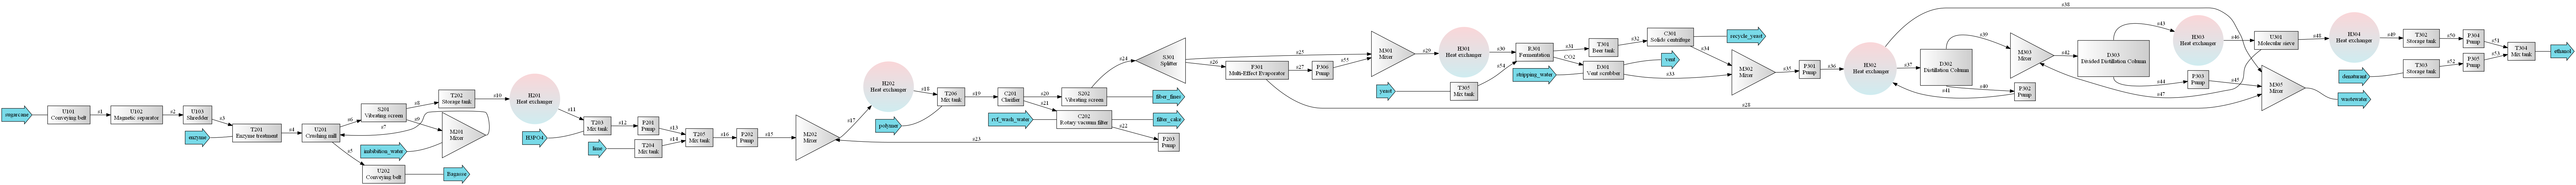

In [4]:
### Helpful functions ###

def mass2molar_ethanol_fraction(x):
    """Return ethanol mol fraction in a ethanol water mixture"""
    return x/46.06844 / (x/46.06844 + (1-x)/18.01528)

### Streams ###
    
# Fresh water
stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')

# Gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=price['Gasoline'])

sugar_solution = S202-0

# Yeast
yeast = bst.Stream('yeast', Water=24700, DryYeast=10300, units='kg/hr')

# Ethanol product
ethanol = bst.Stream('ethanol', price=price['Ethanol'])

### Units ###

# Split sugar solution
S301 = units.Splitter('S301',
                    split=0.265)

# Concentrate sugars
F301 = units.MultiEffectEvaporator('F301',
                                   P=(101325, 73581, 50892, 32777),
                                   V=0.95) # fraction evaporated
# Note: value of steam ~ 6.86 for the following 
# (101325, 73580.467, 50891.17, 32777.406, 19999.925, 11331.5),

# Mix sugar solutions
M301 = units.Mixer('M301')

# Cool for fermentation
H301 = units.HXutility('H301', T=295.15)

# Ethanol Production
R301 = units.Fermentation('R301', outs=('CO2', ''), tau=9, efficiency=0.90, N=4) 
R301.cell_growth_reaction.X = 0. # Ignore for simplicity
T301 = units.StorageTank('T301', tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank'

D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), 
                          outs=('vent', ''),
                          gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4', 'DryYeast'),
                            solids=('DryYeast',))

# Mix in Water
M302 = units.Mixer('M302')
P301 = units.Pump('P301')

# Heat up before beer column
# Exchange heat with stillage
H302 = units.HXprocess('H302', phase0='l', phase1='l', U=1.28)

# Beer column
xbot = mass2molar_ethanol_fraction(0.00001)
ytop = mass2molar_ethanol_fraction(0.574)
D302 = units.BinaryDistillation('D302', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'))
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302')

# Mix ethanol Recycle (Set-up)
M303 = units.Mixer('M303')

ytop = mass2molar_ethanol_fraction(0.9061726)
D303 = units.BinaryDistillation('D303', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303')

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', T=115+273.15, V=1)

# Molecular sieve
U301 = units.MolecularSieve('U301',
                            split=(2165.14/13356.04, 1280.06/1383.85),
                            order=('Ethanol', 'Water'))

# Condense ethanol product
H304 = units.HXutility('H304', 'S149', V=0, T=340.)
T302 = units.StorageTank('T302', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304')

# Storage for gasoline
T303 = units.StorageTank('T303', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305')

# Denatured ethanol product
T304 = units.MixTank('T304', outs=ethanol)
T304.tau = 0.10

# Waste water
M305 = units.Mixer('M305', outs='wastewater')

# Yeast mixing
T305 = units.MixTank('T305')
T305.tau = 0.1
yeast-T305

# Multi-effect evaporator pumps
P306 = units.Pump('P306')


### Ethanol system set-up ###

sugar_solution-S301-1-F301-0-P306
(S301-0, P306-0)-M301-H301
(H301-0, yeast-T305-0)-R301-1-T301-0-C301
(C301-0, D301-1)-M302-P301
(P301-0, P302-0)-H302-0-D302-1-P302
(D302-0, U301-0)-M303-0-D303-0-H303-U301
D303-1-P303

def adjust_denaturant():
    P304._run()
    pure_ethanol = P304.outs[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232

P304.specification = adjust_denaturant
U301-1-H304-0-T302-0-P304
denaturant-T303-P305
(P305-0, P304-0)-T304
(P303-0, F301-1, H302-1)-M305

bst.main_flowsheet.diagram('thorough') # Flow sheet up until now

Define facilities:

In [5]:
s = bst.main_flowsheet.stream
BT = units.BoilerTurbogenerator('BT',
                                (U202-0, '', 'boiler_makeup_water', 'natural_gas', '', ''),
                                boiler_efficiency=0.80,
                                turbogenerator_efficiency=0.85)

CT = units.CoolingTower('CT')
makeup_water_streams = (s.cooling_tower_makeup_water,
                        s.boiler_makeup_water)
process_water_streams = (imbibition_water,
                         rvf_wash_water,
                         stripping_water,
                         *makeup_water_streams)
makeup_water = bst.Stream('makeup_water', price=0.000254)

CWP = units.ChilledWaterPackage('CWP')
PWC = units.ProcessWaterCenter('PWC',
                               (bst.Stream(), makeup_water),
                               (),
                               None,
                               makeup_water_streams,
                               process_water_streams)

Create system and simulate:

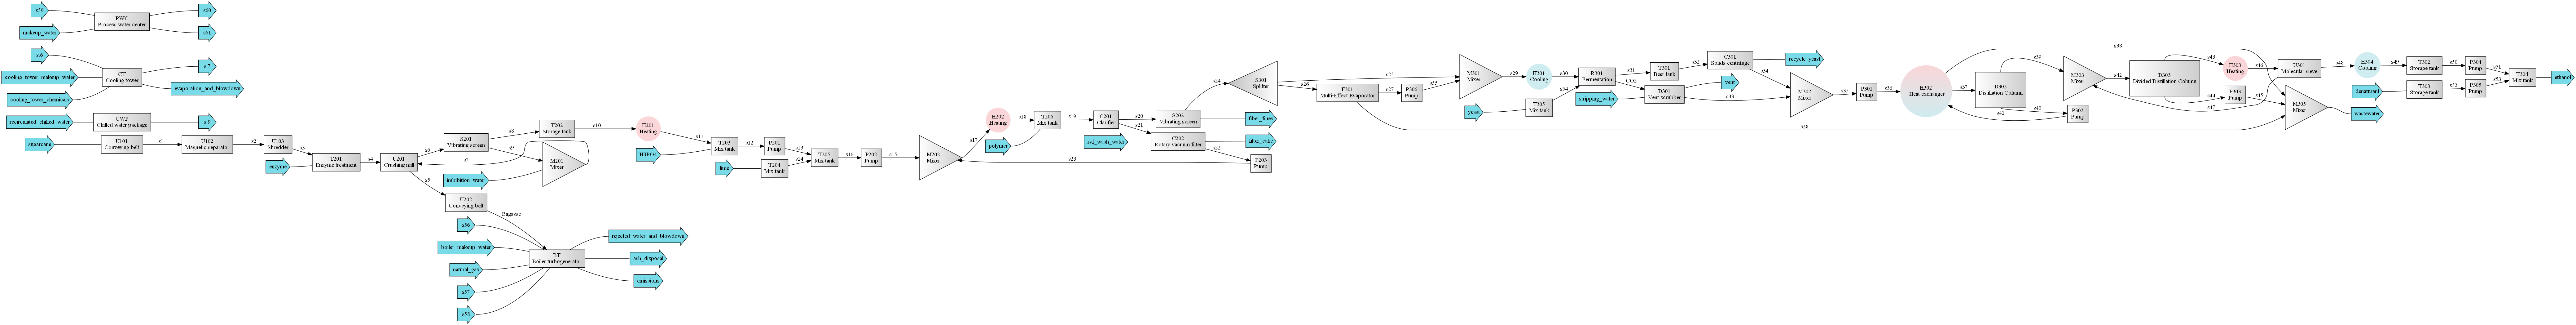

In [6]:
sugarcane_sys = bst.main_flowsheet.create_system('sugarcane_sys')
sugarcane_sys.simulate()
sugarcane_sys.diagram('thorough', format='png')

BioSTEAM generates nested systems to solve recycle streams more robustly. It may be fun to view these systems as follows:

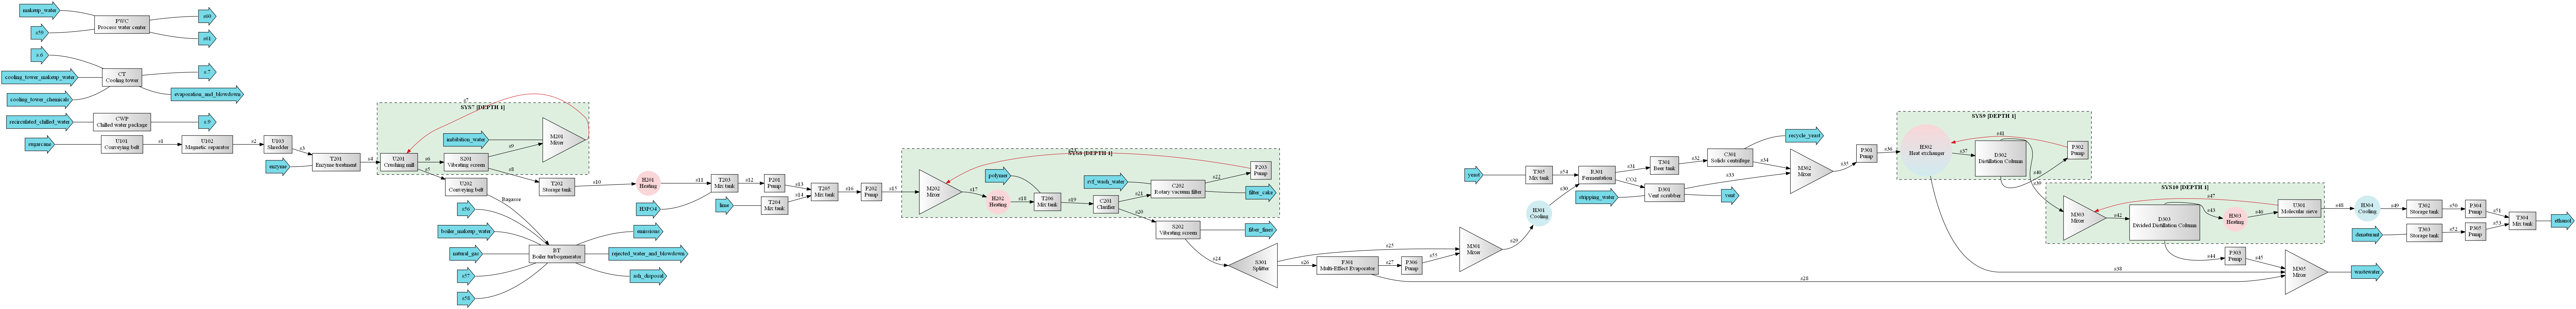

In [7]:
sugarcane_sys.diagram('cluster', format='png') # Red streams are recycles (i.e. tear streams)

In [8]:
sugarcane_sys.print()

System('sugarcane_sys',
    [U101,
     U102,
     U103,
     T201,
     System('SYS7',
        [U201,
         S201,
         M201],
        recycle=M201-0),
     T202,
     H201,
     T203,
     P201,
     T204,
     T205,
     P202,
     System('SYS8',
        [M202,
         H202,
         T206,
         C201,
         C202,
         P203],
        recycle=P203-0),
     S202,
     S301,
     F301,
     P306,
     M301,
     H301,
     T305,
     R301,
     T301,
     C301,
     D301,
     M302,
     P301,
     System('SYS9',
        [H302,
         D302,
         P302],
        recycle=P302-0),
     System('SYS10',
        [M303,
         D303,
         H303,
         U301],
        recycle=U301-0),
     H304,
     T302,
     P304,
     T303,
     P305,
     T304,
     P303,
     M305,
     U202],
    facilities=[BT,
     CWP,
     CT,
     PWC])


Create TEA class and perform techno-economic analysis:

In [9]:
class SugarcaneTEA(bst.TEA):
    """
    Create a SugarcaneTEA object for techno-economic analysis of a biorefinery [1]_.
    
    Parameters
    ----------    
    system : System
        Should contain feed and product streams.
    IRR : float
        Internal rate of return (fraction).
    duration : tuple[int, int]
        Start and end year of venture (e.g. (2018, 2038)).
    depreciation : str
        'MACRS' + number of years (e.g. 'MACRS7').
    operating_days : float
        Number of operating days per year.
    income_tax : float
        Combined federal and state income tax rate (fraction).
    lang_factor : float
        Lang factor for getting fixed capital investment from
        total purchase cost. If no lang factor, estimate capital investment
        using bare module factors.
    startup_schedule : tuple[float]
        Startup investment fractions per year 
        (e.g. (0.5, 0.5) for 50% capital investment in the first year and 50%
        investment in the second).
    WC_over_FCI : float
        Working capital as a fraction of fixed capital investment.
    labor_cost : float
        Total labor cost (USD/yr).
    fringe_benefits : float
        Cost of fringe benefits as a fraction of labor cost.
    property_tax : float
        Fee as a fraction of fixed capital investment.
    property_insurance : float
        Fee as a fraction of fixed capital investment.    
    supplies : float
        Yearly fee as a fraction of labor cost.
    maintenance : float
        Yearly fee as a fraction of fixed capital investment.
    administration : float
        Yearly fee as a fraction of fixed capital investment.

    References
    ----------
    .. [1] Huang, H., Long, S., & Singh, V. (2016). Techno-economic analysis of biodiesel
        and ethanol co-production from lipid-producing sugarcane. Biofuels, Bioproducts
        and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640
    
    """
    
    __slots__ = ('labor_cost', 'fringe_benefits', 'maintenance',
                 'property_tax', 'property_insurance', '_FCI_cached',
                 'supplies', 'maintanance', 'administration')
    
    def __init__(self, system, IRR, duration, depreciation, income_tax,
                 operating_days, lang_factor, construction_schedule, WC_over_FCI,
                 labor_cost, fringe_benefits, property_tax,
                 property_insurance, supplies, maintenance, administration):
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor, construction_schedule,
                         startup_months=0, startup_FOCfrac=0, startup_VOCfrac=0,
                         startup_salesfrac=0, finance_interest=0, finance_years=0, 
                         finance_fraction=0, WC_over_FCI=WC_over_FCI)
        self.labor_cost = labor_cost
        self.fringe_benefits = fringe_benefits
        self.property_tax = property_tax
        self.property_insurance = property_insurance
        self.supplies= supplies
        self.maintenance = maintenance
        self.administration = administration
        
    def _DPI(self, installed_equipment_cost):
        return installed_equipment_cost
        
    def _TDC(self, DPI):
        return DPI
    
    def _FCI(self, TDC):
        self._FCI_cached = TDC
        return TDC
    
    def _FOC(self, FCI):
        return (FCI*(self.property_tax + self.property_insurance
                     + self.maintenance + self.administration)
                + self.labor_cost*(1+self.fringe_benefits+self.supplies))

sugarcane_tea = SugarcaneTEA(system=sugarcane_sys,
                             IRR=0.15,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=200,
                             lang_factor=3,
                             construction_schedule=(0.4, 0.6),
                             WC_over_FCI=0.05,
                             labor_cost=2.5e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

sugarcane_tea.IRR = sugarcane_tea.solve_IRR()
sugarcane_tea.show()

SugarcaneTEA: sugarcane_sys
 NPV: -0 USD at 8.0% IRR


Generate process results with BioSTEAM's UnitGroup objects:

In [10]:
UnitGroup = bst.process_tools.UnitGroup
juicing = UnitGroup('Juicing', 
                    [U101, U102, U103, T201,
                     U201, S201, M201, T202,
                     H201, T203, P201, T204,
                     T205, P202, M202, H202,
                     T206, C201, C202, P203,
                     S202])
ethanol_production = UnitGroup('Ethanol production',
                               [S301, F301, P306, M301,
                                H301, T305, R301, T301,
                                C301, M302, P301, H302,
                                D302, P302, M303, D303,
                                H303, U301, H304, T302,
                                P304, T303, P305, T304,
                                D301, P303, M305])
facilities = UnitGroup('Facilities', sugarcane_sys.facilities)
groups = [juicing, ethanol_production, facilities]
UnitGroup.df_from_groups(groups, with_electricity_production=True)


,Installed equipment cost [MM$],Cooling duty [GJ/hr],Heating duty [GJ/hr],Electricity consumption [MW],Electricity production [MW]
Juicing,19.6,0,95.9,5.29,0
Ethanol production,15.7,258,281,0.392,0
Facilities,63.1,58,0,4.11,15.2


In [11]:
# It is also possible to automatically group units by area
area_groups = UnitGroup.group_by_area(sugarcane_tea.units)
area_names = {'0': 'Facilities',
              '100': 'Feedstock handling',
              '200': 'Juicing',
              '300': 'Ethanol production'}
for i in area_groups: i.name = area_names[i.name]
UnitGroup.df_from_groups(area_groups, with_electricity_production=True)

,Installed equipment cost [MM$],Cooling duty [GJ/hr],Heating duty [GJ/hr],Electricity consumption [MW],Electricity production [MW]
Facilities,63.1,58,0,4.11,15.2
Feedstock handling,5.02,0,0,2.01,0
Juicing,14.7,0,95.9,3.28,0
Ethanol production,15.7,258,281,0.392,0


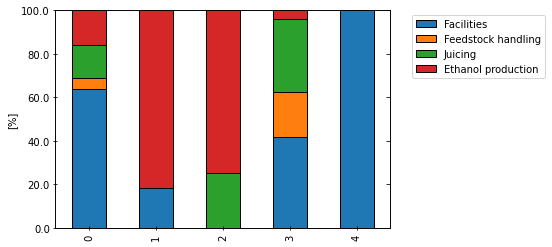

In [12]:
# For convinience, the UnitGroup class also has plotting methods
UnitGroup.plot_bars_from_groups(area_groups, with_electricity_production=True)

### References

<a id='References'></a>

1. Huang, H., Long, S., & Singh, V. (2016) "Techno-economic analysis of biodiesel and ethanol co-production from lipid-producing sugarcane" Biofuels, Bioproducts and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640